# CSS 206 Mini-Project Data Preprocess + Model demos

## Load data files

Assume we have already downloaded csv files in a local folder named "data".

In [193]:
import pandas as pd
import numpy as np
import requests
import sklearn
import nltk
from nltk.stem import PorterStemmer
import seaborn as sns
from unidecode import unidecode
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import spearmanr, pearsonr

In [2]:
# Load local csv files
df_movies = pd.read_csv("./data/movies_metadata.csv")
df_keywords = pd.read_csv("./data/keywords.csv")
df_ratings = pd.read_csv("./data/ratings.csv")

# Download bechdel test score data
address = "http://bechdeltest.com/api/v1/getAllMovies"
response = requests.get(address)
df_scores = pd.read_json(response.text)

/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_87978/3316075403.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_movies = pd.read_csv("./data/movies_metadata.csv")
/var/folders/bt/_dsrh6ld2yncbnn9vk_d2lcc0000gp/T/ipykernel_87978/3316075403.py:9: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_scores = pd.read_json(response.text)


## Combine dataframes

**Let's have a look at dataframes and process id and imdb_id column**

In [3]:
# movies dataframe
print(df_movies.dtypes)
print(df_movies.shape)

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object
(45466, 24)


In [4]:
# keywords dataframe
print(df_keywords.dtypes)
print(df_keywords.shape)

id           int64
keywords    object
dtype: object
(46419, 2)


In [5]:
# rating dataframe
print(df_ratings.dtypes)
print(df_ratings.shape)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object
(26024289, 4)


In [6]:
# scores dataframe
print(df_scores.dtypes)
print(df_scores.shape)

year       int64
title     object
id         int64
imdbid    object
rating     int64
dtype: object
(10493, 5)


In [7]:
# Preprocess "id" and "imdb_id" columns in df_movies

# "id" in df_movies is str, "id" in df_ratings and df_keywords is int64
df_movies["id"] = pd.to_numeric(df_movies["id"], errors="coerce")
df_movies.dropna(subset=["id"], inplace=True)
df_movies["id"] = df_movies["id"].astype("int64")

# imdbid in df_movies and df_scores both are str
# imdbid in df_movies has additonal "tt" prefix, so we remove it
df_movies["imdb_id"] = df_movies["imdb_id"].str[2:]

In [8]:
# Check number of data after intersection
s1_id = set(df_movies["id"])
s1_imdb = set(df_movies["imdb_id"])
s2_id = set(df_keywords["id"])
s3_id = set(df_ratings["movieId"])
s4_imdb = set(df_scores["imdbid"])

print(f"Data in s1 intersect s2: {len(s1_id & s2_id)}")
print(f"Data in s1 intersect s3: {len(s1_id & s3_id)}")
print(f"Data in s1 intersect s4: {len(s1_imdb & s4_imdb)}")

Data in s1 intersect s2: 45432
Data in s1 intersect s3: 7565
Data in s1 intersect s4: 7985


There will be even less data if we combine 4 dataframes together.

**Then, let's merge df_movies with other 3 dataframes**

In [9]:
# Combine df_movies and df_keywords together
# Combine and retain only matching rows
df_movies = df_movies.merge(df_keywords, on="id")

In [10]:
# Combine df_movies and df_ratings together
# Calculate average ratings
df_ratings = df_ratings.groupby("movieId")["rating"].mean().reset_index()
df_ratings.columns = ["id", "rating"]

# Combine and retain only matching rows
df_movies = df_movies.merge(df_ratings, on="id")

In [11]:
# Combine df_movies and df_scores together
df_scores = df_scores[["imdbid", "rating"]]
df_scores.columns = ["imdb_id", "bechdel_score"]

# Combine and retain only matching rows
df_movies = df_movies.merge(df_scores, on="imdb_id")

**There only 2k+ rows data now.**

In [12]:
# If you want to save memory 
del df_keywords
del df_ratings
del df_scores

## Change data type

In [13]:
# Check column names and types in df_movies
print(df_movies.dtypes)

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                         int64
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
keywords                  object
rating                   float64
bechdel_score              int64
dtype: object


# Add categorical data
`genres`, `spoken_languages`, `original_language`, `production_countries`

Ignoring `production_companies` because there are more unique values than there are rows.

In [14]:
df_movies['spoken_languages']

0                [{'iso_639_1': 'en', 'name': 'English'}]
1       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
3       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4       [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
                              ...                        
2162             [{'iso_639_1': 'en', 'name': 'English'}]
2163         [{'iso_639_1': 'xx', 'name': 'No Language'}]
2164    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
2165             [{'iso_639_1': 'en', 'name': 'English'}]
2166         [{'iso_639_1': 'xx', 'name': 'No Language'}]
Name: spoken_languages, Length: 2167, dtype: object

In [15]:
df_movies['spoken_language_iso']=df_movies['spoken_languages'].apply(eval).apply(lambda l: [x['iso_639_1'] for x in l])
df_movies['genre_names']=df_movies['genres'].apply(eval).apply(lambda l: [x['name'] for x in l])
df_movies['country_names']=df_movies['production_countries'].apply(eval).apply(lambda l: [x['name'] for x in l])

In [16]:
genres = set()
df_movies['genre_names'].apply(genres.update)
len(genres)

20

In [17]:
original_language = set()
df_movies['original_language'].dropna().apply(original_language.add)
len(original_language)

33

In [18]:
spoken_languages = set()
df_movies['spoken_language_iso'].apply(spoken_languages.update)
len(spoken_languages)

72

In [19]:
production_countries = set()
df_movies['country_names'].apply(production_countries.update)
len(production_countries)

73

In [20]:
# production_companies = set()
# df_movies['production_companies'].apply(lambda l: production_companies.update([x['name'] for x in l]))
# len(production_companies)
# 2813

For multi-valued categorical variables, decompose into 1-hot columns

In [21]:
categorical_vars = {
    'genre_names': genres,
    'spoken_language_iso': spoken_languages,
    'country_names': production_countries
}
onehot_dict = {}
for varname, values in categorical_vars.items():
    for var in values:
        colname = varname+'_'+var
        varcol = np.zeros(len(df_movies), dtype=int)
        onehot_dict[colname]=varcol
        varcol[:]=0
        has_var = df_movies[varname].apply(lambda l: var in l)
        varcol[has_var]=1

genre_cols = [col for col in onehot_dict if 'genre' in col]
cntry_cols = [col for col in onehot_dict if 'countr' in col]
lang_cols = [col for col in onehot_dict if 'spoken' in col]
onehot_df = pd.DataFrame(onehot_dict)
onehot_cols = onehot_df.columns.tolist()
df_movies = pd.concat([df_movies, onehot_df], axis=1)
# pd.concat([df_movies, onehot_df])

df_movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,country_names_Finland,country_names_Thailand,country_names_Palestinian Territory,country_names_Soviet Union,country_names_Mongolia,country_names_Uruguay,country_names_Hungary,country_names_Greece,country_names_Ukraine,country_names_Sweden
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,0,0,0,0,0,0,0,0,0,0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,0,0,0,0,0,0,0,0,0,0
2,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,0,0,0,0,0,0,0,0,0,0
3,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,0,0,0,0,0,0,0,0,0,0
4,False,NaN,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,1408,0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Convert budget and popularity column from string to float
df_movies["budget"] = df_movies["budget"].astype(float)
df_movies["popularity"] = df_movies["popularity"].astype(float)

# Columns with continuous data
cont_cols = ["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count", "rating"]
print(len(cont_cols), len(onehot_cols))

7 165


Encode categorical variables as integers

In [23]:
from sklearn.preprocessing import LabelEncoder
cat_cols = []
category_names = ['belongs_to_collection', 'genres', 'original_language', 'production_countries']
for cat in category_names:
    colname = cat+'_encoded'
    df_movies[colname] = LabelEncoder().fit_transform(df_movies[cat].apply(str))
    cat_cols.append(colname)
df_movies[cat_cols]

,belongs_to_collection_encoded,genres_encoded,original_language_encoded,production_countries_encoded
0,5,218,8,296
1,0,73,8,296
2,0,478,8,296
3,242,129,8,188
4,0,416,8,139
...,...,...,...,...
2162,0,577,8,296
2163,0,514,12,169
2164,178,87,17,226
2165,0,4,8,296


In [24]:
cont_cols

['budget',
 'popularity',
 'revenue',
 'runtime',
 'vote_average',
 'vote_count',
 'rating']

In [25]:
from sklearn.preprocessing import KBinsDiscretizer

bin10_cols = []
bin2_cols = []

bin10er=KBinsDiscretizer(n_bins=10, encode='ordinal')
bin2er=KBinsDiscretizer(n_bins=2, encode='ordinal')

for col in cont_cols:
    bin10_col = col+'_bin10'
    # print(col, bin10_col)
    df_movies[bin10_col]=bin10er.fit_transform(df_movies[col].to_numpy()[:,np.newaxis])
    bin10_cols.append(bin10_col)

    bin2_col = col+'_bin2'
    df_movies[bin2_col]=bin2er.fit_transform(df_movies[col].to_numpy()[:,np.newaxis])
    bin2_cols.append(bin2_col)
bin10_cols

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_discretization.py:322: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


['budget_bin10',
 'popularity_bin10',
 'revenue_bin10',
 'runtime_bin10',
 'vote_average_bin10',
 'vote_count_bin10',
 'rating_bin10']

# Add bag of word columns

In [26]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.model_selection import cross_validate
# from sklearn.naive_bayes import MultinomialNB, ComplementNB
# vectorizer = CountVectorizer(stop_words='english')

# stemmer = PorterStemmer()
# df_movies['keyword_str'] = df_movies['keywords'].apply(lambda l: ' '.join(x['name'] for x in l) if type(l) is list else l)
# word_columns = ["overview", "keyword_str", "tagline"]
# stemmed_cols = []
# bow_list = []
# x_idcs = df_movies.dropna().index
# for col in word_columns:
#     stemmed_col = df_movies.loc[x_idcs, col].apply(lambda s: ' '.join([stemmer.stem(w) for w in s.split()]) if type(s) is str else np.nan)
#     model = MultinomialNB()
#     bow = vectorizer.fit_transform(stemmed_col).toarray()
#     bow_list.append(bow)
# y = df_movies['bechdel_score'].loc[x_idcs]
# x_cat = df_movies.loc[x_idcs, onehot_cols].values
# x_cont = df_movies.loc[x_idcs, cont_cols].values
# subsets = get_subsets(bow_list)
# for subset in subsets:
#     X = np.concatenate(subset, axis=1)
#     cv = do_cv(model, X, y)


In [27]:
df_train = df_movies[cont_cols+onehot_cols+cat_cols+bin10_cols+bin2_cols+['bechdel_score']]
df_train.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,rating,genre_names_History,genre_names_Family,genre_names_War,...,vote_count_bin10,rating_bin10,budget_bin2,popularity_bin2,revenue_bin2,runtime_bin2,vote_average_bin2,vote_count_bin2,rating_bin2,bechdel_score
0,30000000.0,21.946943,373554033.0,81.0,7.7,5415.0,3.598930,0,1,0,...,9.0,7.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1
1,65000000.0,17.015539,262797249.0,104.0,6.9,2413.0,3.760163,0,1,0,...,9.0,8.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,3
2,60000000.0,17.924927,187436818.0,170.0,7.7,1886.0,3.905544,0,0,0,...,8.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2
3,58000000.0,14.686036,352194034.0,130.0,6.6,1194.0,2.740334,0,0,0,...,8.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,3
4,98000000.0,7.284477,10017322.0,119.0,5.7,137.0,3.710181,0,0,0,...,3.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1


## Resample data

In [28]:
df_train['bechdel_score'].value_counts()

bechdel_score
3    1073
1     553
2     274
0     267
Name: count, dtype: int64

In [29]:
from sklearn.utils import resample
resample_n = sum(df_train['bechdel_score']==3)
resampled_X = []
for score in range(4):
    score_mask = df_train['bechdel_score'] == score
    score_resampled = resample(df_train[score_mask], n_samples=resample_n)
    resampled_X.append(score_resampled)
df_resampled = pd.concat(resampled_X)
df_resampled.shape, df_resampled['bechdel_score'].value_counts()

((4292, 191),
 bechdel_score
 0    1073
 1    1073
 2    1073
 3    1073
 Name: count, dtype: int64)

## Normalize dataset

In [30]:
# data = df_train.values
data = df_resampled

# Shuffle data, you may change seed
data = data.sample(frac=1, random_state=42)

# split features and label
X = data.drop('bechdel_score', axis=1)
y = data['bechdel_score']

# Change data type
# x_cont = x_cont.astype(np.float32)
y = y.astype(np.int32) # We use float in regression and int in classification
X[cont_cols]=X[cont_cols].astype(np.float32)
X[cat_cols]=X[cat_cols].astype(np.int32)
X[onehot_cols]=X[onehot_cols].astype(np.int32)
X[bin10_cols]=X[bin10_cols].astype(np.int32)
X[bin2_cols]=X[bin2_cols].astype(np.int32)

Z-score continuous features

In [31]:
train_mean, train_std = np.mean(X[cont_cols], axis=0), np.std(X[cont_cols], axis=0)
X[cont_cols] = (X[cont_cols] - train_mean) / train_std

Commenting this out so we can do $k$-fold cross validation instead of train/test validation

In [32]:
# # split train dataset and test dataset, you may change the ratio
# train_ratio = 0.9
# threshold = int(train_ratio * len(y))
# x_cont_train = x_cont[:threshold, :]
# x_cont_test = x_cont[threshold:, :]

# x_cat_train = x_cat[:threshold, :]
# x_cat_test = x_cat[threshold:, :]

# y_train = y[:threshold]
# y_test = y[threshold:]

# # Feature scaling with Z-score
# train_mean, train_std = np.mean(x_cont_train, axis=0), np.std(x_cont_train, axis=0)
# x_cont_train = (x_cont_train - train_mean) / train_std
# x_cont_test  = (x_cont_test  - train_mean) / train_std

Then you can go training model with (x_train, y_train), and test model with (x_test, y_test)

## Train models
Sticking to Guassian Naive Bayes and Bernouilli Naive Bayes

In [93]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, f1_score

def do_cv(model, X, y, exp_name=''):
    cv = cross_validate(estimator=model, X=X, y=y, scoring=['f1_macro', 'accuracy'], cv=10)
    cv_acc = cv['test_accuracy'].mean()
    cv_acc_std = cv['test_accuracy'].std()
    cv_f1 = cv['test_f1_macro'].mean()
    cv_f1_std = cv['test_f1_macro'].std()
    model_name = model.__str__().split('(')[0]
    print(f"{exp_name}\t{model_name}\n{cv_acc=:.2f}\t{cv_acc_std=:.2f}\t{cv_f1=:.2f}\t{cv_f1_std=:.2f}")
    return {
        "mean_acc": cv_acc,
        "acc_std": cv_acc_std,
        "mean_f1": cv_f1,
        "f1_std": cv_f1_std,
        "exp_name": exp_name
    }

In [94]:
rows = []

y_naive = np.full_like(y, fill_value=3)
# loss = mean_squared_error(y, y_naive)
acc = np.mean(y_naive[:] == y[:])
f1 = f1_score(y, y_naive, average='macro')
print(f"Naive: {acc=:.2f} {f1=:.2f}")
rows.append({
    "mean_acc": acc,
    "mean_f1": f1,
    "model_name": "Baseline",
    "exp_name": "Baseline",
})


model = GaussianNB()
rows.append(do_cv(model, X[cont_cols], y, 'Continuous features'))

# for feature in cont_cols:
#     print(feature)
#     do_cv(model, X[feature].to_numpy()[:, np.newaxis], y)

# print("Bin-10 features")
# model = GaussianNB()
# do_cv(model, X[bin10_cols], y)

model = BernoulliNB()
rows.append(do_cv(model, X[bin2_cols], y, "Binned continuous features"))

model = BernoulliNB()
rows.append(do_cv(model, X[onehot_cols], y, "Multi-hot features"))

model = BernoulliNB()
rows.append(do_cv(model, X[onehot_cols+bin2_cols], y, "Multi-hot + binned features"))

model = BernoulliNB()
rows.append(do_cv(model, X[cntry_cols], y, "Production country"))

model = BernoulliNB()
rows.append(do_cv(model, X[lang_cols], y, "Languages spoken"))

print("Genre features")
model = BernoulliNB()
rows.append(do_cv(model, X[genre_cols], y, "Movie genres"))

# print("Categorical features")
# do_cv(model, X[cat_cols], y)

# print("Categorical+bin10 features")
# do_cv(model, X[cat_cols+bin10_cols], y)

# print("All features")
# model = GaussianNB()
# do_cv(model, X, y)

# model = BernoulliNB()
# do_cv(model, X, y)

results = pd.DataFrame(rows)
results.head()

Naive: acc=0.25 f1=0.10
Continuous features	GaussianNB
cv_acc=0.27	cv_acc_std=0.02	cv_f1=0.20	cv_f1_std=0.02
Binned continuous features	BernoulliNB
cv_acc=0.31	cv_acc_std=0.02	cv_f1=0.28	cv_f1_std=0.03
Multi-hot features	BernoulliNB
cv_acc=0.41	cv_acc_std=0.02	cv_f1=0.41	cv_f1_std=0.02
Multi-hot + binned features	BernoulliNB
cv_acc=0.41	cv_acc_std=0.01	cv_f1=0.41	cv_f1_std=0.01
Production country	BernoulliNB
cv_acc=0.32	cv_acc_std=0.02	cv_f1=0.28	cv_f1_std=0.02
Languages spoken	BernoulliNB
cv_acc=0.31	cv_acc_std=0.02	cv_f1=0.28	cv_f1_std=0.03
Genre features
Movie genres	BernoulliNB
cv_acc=0.37	cv_acc_std=0.03	cv_f1=0.35	cv_f1_std=0.03


,mean_acc,mean_f1,model_name,exp_name,acc_std,f1_std
0,0.250000,0.100000,Baseline,Baseline,NaN,NaN
1,0.274000,0.202403,NaN,Continuous features,0.017413,0.018571
2,0.312443,0.280558,NaN,Binned continuous features,0.021964,0.025865
3,0.413796,0.413036,NaN,Multi-hot features,0.019202,0.018763
4,0.413560,0.411932,NaN,Multi-hot + binned features,0.014330,0.014881


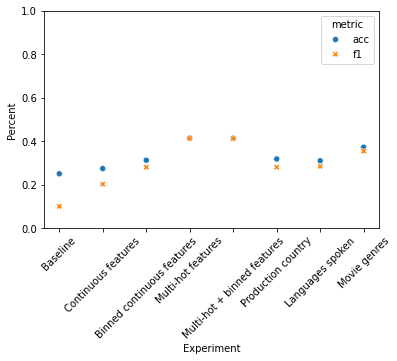

In [125]:
results_vals = results.melt(id_vars=["exp_name", "model_name"], value_vars=["mean_acc", "mean_f1"], value_name='value')
results_std = results.melt(id_vars=["exp_name", "model_name"], value_vars=["acc_std", "f1_std"], value_name='std')

for df in results_vals, results_std:
    df['metric']='acc'
    df.loc[df['variable'].str.contains('f1'), 'metric']='f1'
    df.set_index(["exp_name", "model_name", "metric"], inplace=True)
    df.drop("variable", inplace=True, axis=1)
# results_std
results_long = results_vals.join(results_std)
g=sns.scatterplot(results_long, x="exp_name", y="value", hue="metric", style="metric")
# g.set_xlim(0,1)
g.tick_params(axis='x', rotation=45)
g.set_ylim(0,1)
g.set_ylabel("Percent")
g.set_xlabel("Experiment")
plt.show()

In [196]:
def get_corridcs(m: np.ndarray):
    m[np.isnan(m)]=0
    row_indices = np.arange(len(m))
    num_cols = m.shape[1]
    corrvals = np.empty(num_cols)
    for j in range(num_cols):
        corr, _ = pearsonr(m[:,j], row_indices)
        if np.isnan(corr):
            corr=0
        corrvals[j]=corr
    corridcs = np.argsort(corrvals)
    return corridcs

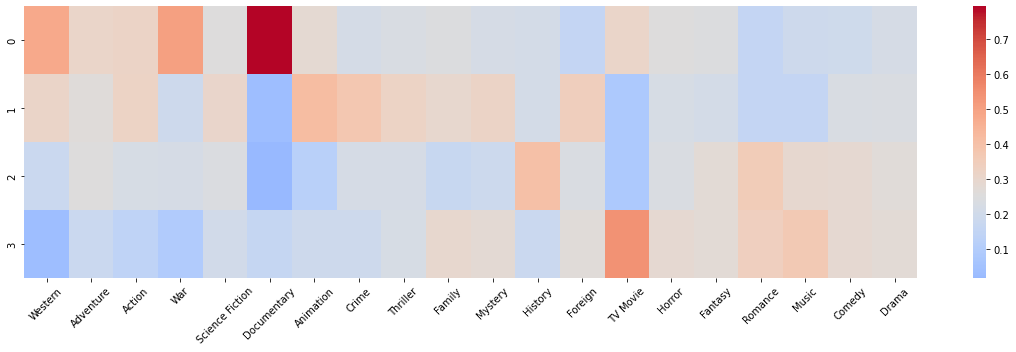

In [197]:
plt.figure(figsize=(20,5))

model = BernoulliNB()
genre_cols_heatmap = sorted(genre_cols)
model.fit(X[genre_cols_heatmap], y)
col_labels = [unidecode(x.split('_')[-1]) for x in genre_cols_heatmap]
col_labels = np.array(col_labels)
genre_probs = model.feature_log_prob_
genre_probs = softmax(genre_probs, axis=0)
sort_idcs = get_corridcs(genre_probs)
g=sns.heatmap(genre_probs[:, sort_idcs], xticklabels=col_labels[sort_idcs], cmap='coolwarm', center=0.25)
g.set_xticklabels(col_labels[sort_idcs], rotation=45)
plt.show()

In [36]:
X[genre_cols_heatmap].shape, len(genre_cols_heatmap)

((4292, 20), 20)

/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


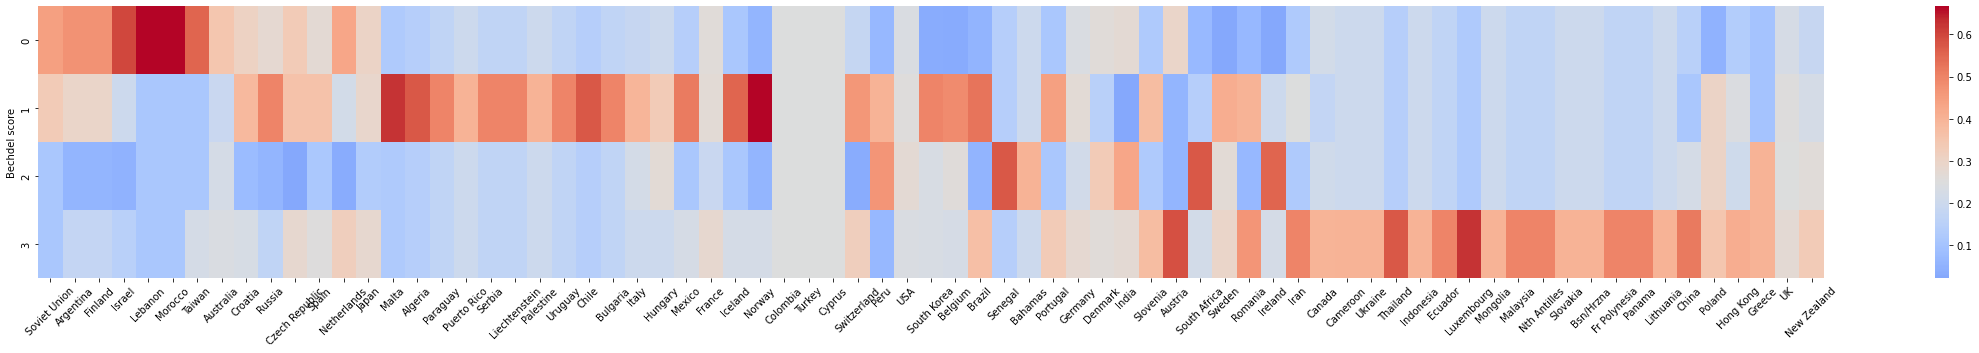

In [198]:
plt.figure(figsize=(40,5))

model = BernoulliNB()
cntry_cols_heatmap = sorted(cntry_cols)
model.fit(X[cntry_cols_heatmap], y)
col_labels = [unidecode(x.split('_')[-1]) for x in cntry_cols_heatmap]
abbreviated_cntries = {
    'United States of America': 'USA',
    'Bosnia and Herzegovina': 'Bsn/Hrzna',
    'Palestinian Territory': 'Palestine',
    'French Polynesia': 'Fr Polynesia',
    'Netherlands Antilles': 'Nth Antilles',
    'United Kingdom': 'UK',
}
col_labels = [abbreviated_cntries.get(x, x) for x in col_labels]
col_labels = np.array(col_labels)
cntry_probs = model.feature_log_prob_
cntry_probs = softmax(cntry_probs, axis=0)
sort_idcs = get_corridcs(cntry_probs)
g=sns.heatmap(cntry_probs[:,sort_idcs], xticklabels=col_labels[sort_idcs], cmap='coolwarm', center=0.25)
g.set_ylabel('Bechdel score')
g.set_xticklabels(col_labels[sort_idcs], rotation=45)
plt.show()

/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


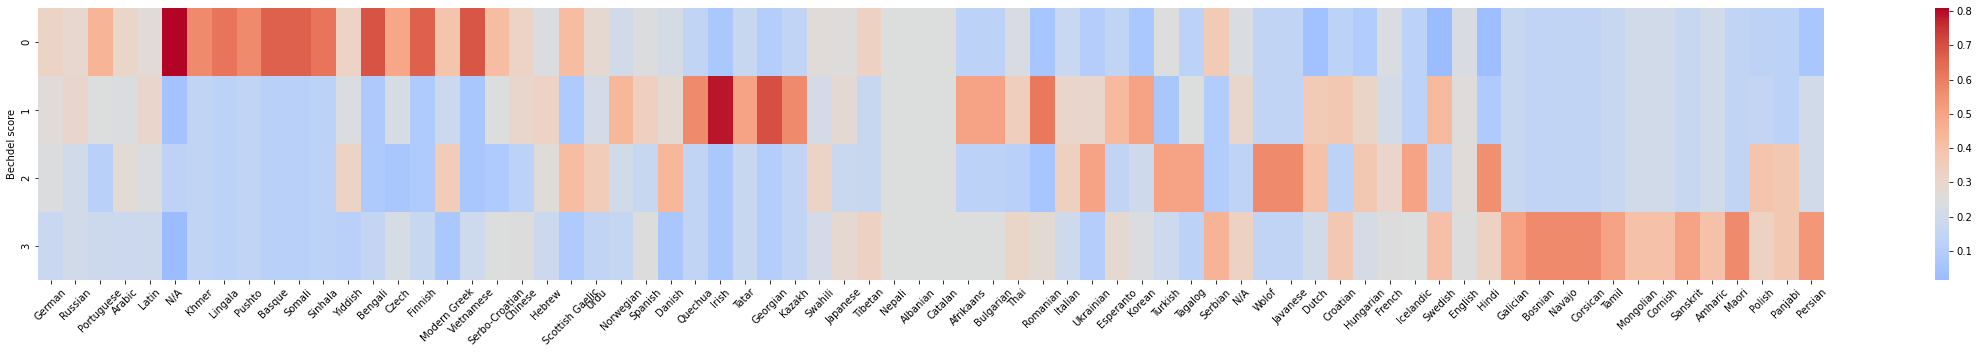

In [199]:
plt.figure(figsize=(40,5))

import pycountry
def get_langname(iso):
    lang = pycountry.languages.get(alpha_2=iso)
    if lang:
        return lang.name
    if lang=='cn':
        return 'Chinese'
    return 'N/A'


model = BernoulliNB()
lang_cols_heatmap = sorted(lang_cols)
model.fit(X[lang_cols_heatmap], y)
col_labels = [unidecode(x.split('_')[-1]) for x in lang_cols_heatmap]
col_labels = [get_langname(x) for x in col_labels]
abbreviated_langs = {
    'Modern Greek (1453-)': 'Modern Greek',
    'Nepali (macrolanguage)': 'Nepali',
    'Swahili (macrolanguage)': 'Swahili',
}
col_labels = [abbreviated_langs.get(x, x) for x in col_labels]
col_labels = np.array(col_labels)
lang_probs = model.feature_log_prob_
lang_probs = softmax(lang_probs, axis=0)
sort_idcs = get_corridcs(lang_probs)
g=sns.heatmap(lang_probs[:,sort_idcs], xticklabels=col_labels[sort_idcs], cmap='coolwarm', center=0.25)
g.set_ylabel('Bechdel score')
g.set_xticklabels(col_labels[sort_idcs], rotation=45)
plt.show()

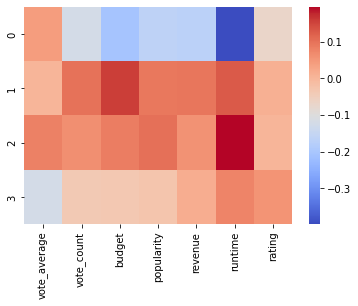

In [201]:
model = GaussianNB()
model.fit(X[cont_cols], y)
feat_probs=model.theta_
# feat_probs=softmax(feat_probs, axis=0)
sort_idcs = get_corridcs(feat_probs)
col_labels=np.array(cont_cols)
sns.heatmap(feat_probs[:,sort_idcs], xticklabels=col_labels[sort_idcs], cmap='coolwarm')
plt.show()

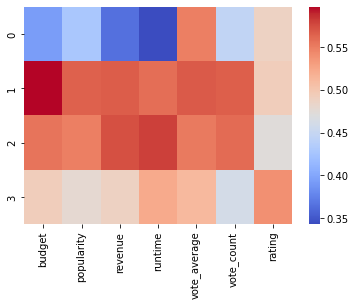

In [126]:
model = GaussianNB()
model.fit(X[bin2_cols], y)
feat_probs=model.theta_
# feat_probs=softmax(feat_probs, axis=0)
sns.heatmap(feat_probs, xticklabels=cont_cols, cmap='coolwarm')
plt.show()